# Analyzing snATAC-seq data of human colon samples

In [1]:
import snapatac2 as snap
import anndata as ad
from os import listdir
import numpy as np

In [2]:
files = !ls data/*_fragments.bed.gz

In [3]:
files

['data/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz',
 'data/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz',
 'data/colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz',
 'data/colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz',
 'data/colon_transverse_SM-CSSDA_rep1_fragments.bed.gz']

In [4]:
datasets = {}
for fl in files:
    print(fl)
    name = fl.split("_rep1_fragments")[0]
    
    # Compute QC metric and cell by 500bp-bin matrix
    data = snap.make_tile_matrix(name + "_raw.h5ad",
        fl,
        "/projects/ps-renlab/kai/genome/GRCh38/gencode.v33.basic.annotation.gtf",
        snap.hg38)
    
    # Select cells based on number of unique fragments and TSS enrichment scores
    selected_cells = np.logical_and(data.obs["n_fragment"] >= 1000, data.obs["tsse"] >= 7)
    data = data[selected_cells, :]
    
    # Save filtered data to a different file
    data.copy(filename = name + "_filtered.h5ad")
    datasets[name] = data


data/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz
data/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz
data/colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz
data/colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz
data/colon_transverse_SM-CSSDA_rep1_fragments.bed.gz


In [5]:
datasets

{'data/colon_transverse_SM-A9HOW': View of AnnData object with n_obs × n_vars = 7512 × 6176550 backed at 'data/colon_transverse_SM-A9HOW_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'data/colon_transverse_SM-A9VP4': View of AnnData object with n_obs × n_vars = 2438 × 6176550 backed at 'data/colon_transverse_SM-A9VP4_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'data/colon_transverse_SM-ACCQ1': View of AnnData object with n_obs × n_vars = 1332 × 6176550 backed at 'data/colon_transverse_SM-ACCQ1_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'data/colon_transverse_SM-BZ2ZS': View of AnnData object with n_obs × n_vars = 6174 × 6176550 backed at 'data/colon_transverse_SM-BZ2ZS_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'data/colon_transverse_SM-CSSDA': View of AnnData object with n_obs × n_vars = 7511 × 6176550 backed at 'data/colon_transverse_SM-CSSDA_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac

In [6]:
# Merge all data. The resultant object stores references to individual data.
# Data will not be copied but remain on the disk
data = ad.experimental.AnnCollection(
    datasets,
    index_unique = "_",
    join_obsm="inner",
    label="batch"
)
data

AnnCollection object with n_obs × n_vars = 24967 × 6176550
  constructed from 5 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'batch'

In [7]:
# Feature selection
features = snap.select_features(data, whitelist="data/cCRE_hg38.bed.gz")

In [10]:
# Perform dimension reduction. The result is stored in `data.obsm["X_spectral"]
snap.spectral(data, features=features, sample_size=10000, chunk_size=5000)

Compute similarity matrix
Normalization
Perform decomposition
Perform Nystrom extension


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.51s/it]


In [11]:
# Perform UMAP
snap.umap(data)

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


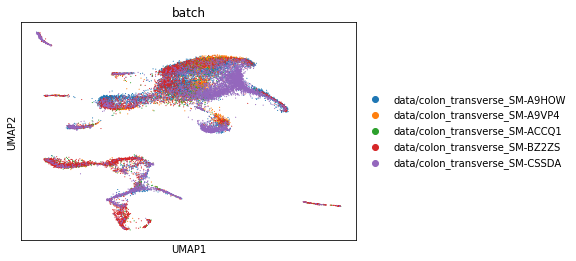

In [12]:
import scanpy as sc
sc.pl.umap(data.to_adata(), color="batch")

In [ ]:
# Save the result to file
data.to_adata().write("out.h5ad")

In [13]:
data

AnnCollection object with n_obs × n_vars = 24967 × 6176550
  constructed from 5 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    obsm: 'X_spectral', 'X_umap'

In [14]:
data.var_names

Index(['chr1:0-500', 'chr1:500-1000', 'chr1:1000-1500', 'chr1:1500-2000',
       'chr1:2000-2500', 'chr1:2500-3000', 'chr1:3000-3500', 'chr1:3500-4000',
       'chr1:4000-4500', 'chr1:4500-5000',
       ...
       'chrY:57222500-57223000', 'chrY:57223000-57223500',
       'chrY:57223500-57224000', 'chrY:57224000-57224500',
       'chrY:57224500-57225000', 'chrY:57225000-57225500',
       'chrY:57225500-57226000', 'chrY:57226000-57226500',
       'chrY:57226500-57227000', 'chrY:57227000-57227415'],
      dtype='object', name='Region', length=6176550)

In [8]:
np.count_nonzero(features)

1721417

In [9]:
data

AnnCollection object with n_obs × n_vars = 24967 × 6176550
  constructed from 5 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'batch'